## Load data

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
from pathlib import Path
import os

In [2]:
# table = pd.read_csv('/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/data/raw/psm_tables/bern+cologne/mapping/multicentricTableAllImprovedOnlyRev04B.csv')
table = pd.read_csv('/Users/jan/Downloads/deepmaps/data/raw/psm_tables/bern+cologne/mapping/multicentricTableAllImprovedOnlyRev04B.csv')

table = table[table['centerID'] == 1]
filenames = table['filename'].to_list()

# table contains relative paths in 'filename' columns, making it absolute
def filename_process(filename):
    path = '/Users/jan/Downloads/deepmaps/data/raw/original_vtas/VTAsForMulticentricPSMRev04B/' + '/'.join(filename.split('/')[-2:])
    return os.path.abspath(path)
    
filenames = list(map(filename_process, filenames))

In [3]:
print(filenames[0])
img = nib.load(filenames[0])
hdr = img.header
print(hdr)
print(img.get_data_dtype())
print(img.shape)
print(os.path.getsize(filenames[0]))
print(type(img))

/Users/jan/Downloads/deepmaps/data/raw/original_vtas/VTAsForMulticentricPSMRev04B/BernVTAsResliced/0001_8_2.5.nii
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 53 53 53  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    0.25  0.25  0.25  0.    0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d  

## Plot VTA

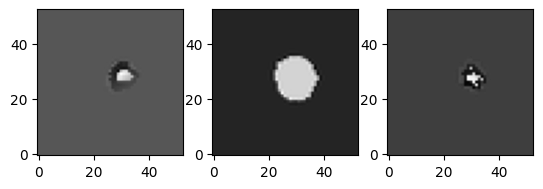

In [4]:
import matplotlib.pyplot as plt

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
       
data = img.get_fdata()
slice_0 = data[14, :, :]
slice_1 = data[:, 30, :]
slice_2 = data[:, :, 16]

show_slices([slice_0, slice_1, slice_2])

plt.show()

## Affines

In [5]:
img.affine

array([[ -0.25,  -0.  ,   0.  ,  19.  ],
       [ -0.  ,   0.25,  -0.  , -21.  ],
       [  0.  ,   0.  ,   0.25, -16.  ],
       [  0.  ,   0.  ,   0.  ,   1.  ]])

In [6]:
import nibabel.processing
res = 0.25
resampled_img = nibabel.processing.resample_to_output(img, voxel_sizes=(res, res, res))

In [7]:
resampled_img.affine

array([[  0.25,   0.  ,   0.  ,   6.  ],
       [  0.  ,   0.25,   0.  , -21.  ],
       [  0.  ,   0.  ,   0.25, -16.  ],
       [  0.  ,   0.  ,   0.  ,   1.  ]])

## Concatenate all the imgs

In [117]:
from tqdm import tqdm

img = nib.load(filenames[0])
comspa_img, imgs = [], []
for filename in tqdm(filenames):
    curr_img = nib.load(filename)
    imgs.append(curr_img)
    #comspa_img.append(nibabel.processing.resample_from_to(curr_img, img)) 


100%|██████████| 660/660 [00:00<00:00, 812.59it/s]


In [118]:
print(len(imgs))

660


In [119]:
def get_affines(imgs):
    affines = []
    for img in tqdm(imgs):
        affines.append(img.affine)
    return np.array(affines)
affines = get_affines(imgs)
print(affines.shape)    

100%|██████████| 660/660 [00:00<00:00, 509335.90it/s]

(660, 4, 4)


## Histplot affines

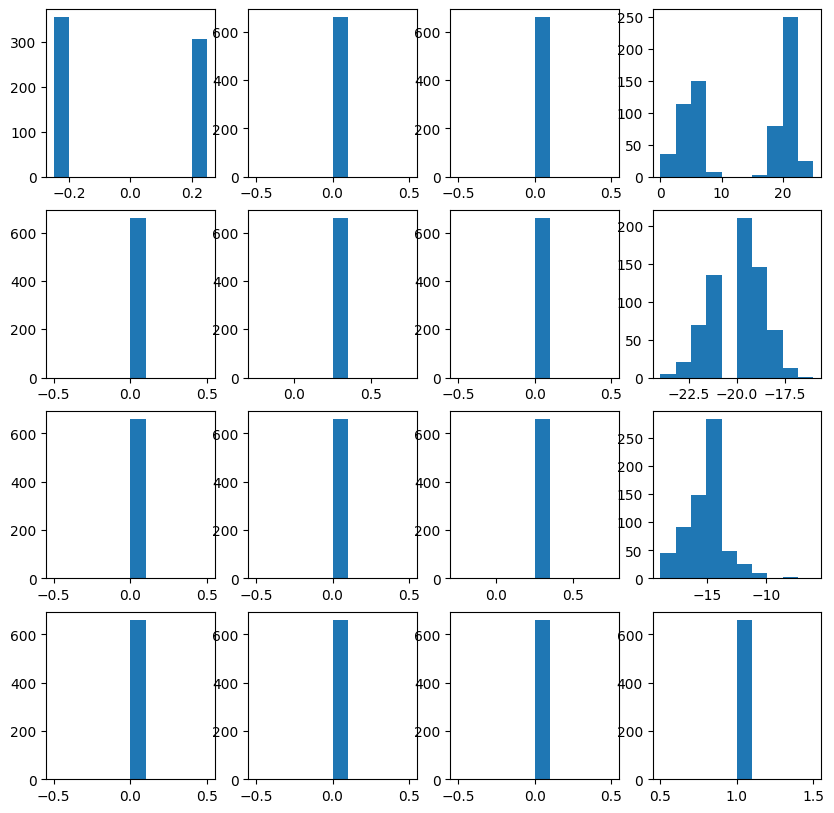

In [12]:
import matplotlib.pyplot as plt

def plot_affines(affines):
    fig, axs = plt.subplots(ncols=4,nrows=4, figsize=(10,10))
    for i in range(4):
        for j in range(4):
            axs[i,j].hist(affines[:,i,j])

plot_affines(affines)

We are in MNI space : origin (0,0,0) at the anterior comissure of the brain.
Affine transform matrix histograms indicates :
- 0.25 mm resolution for all 3 dimensions
- x-plane is switched (left, right) sometimes. hypothesis : this depends strictly on VTA hemisphere.
- x-offset might be positive and negative depending on the side
- y-offset strictly negative (-25, -15)
- z-offset strictly negative (-20, -5)

## Switch affines side Left to Right

100%|██████████| 660/660 [00:00<00:00, 998643.81it/s]


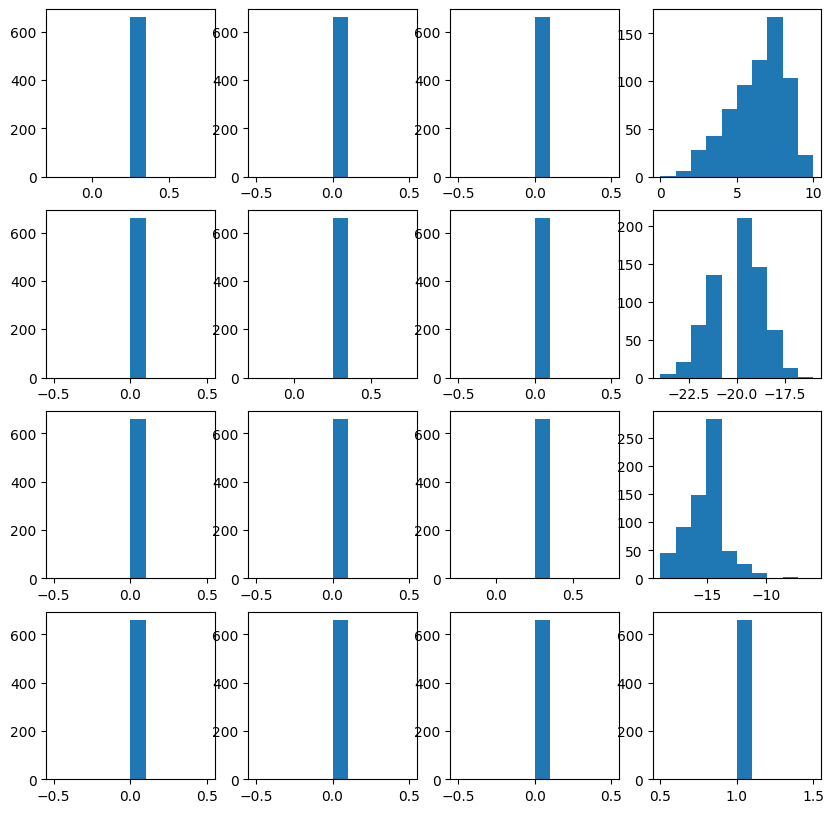

In [13]:
def switch_side(img):
    res = 0.25
    return nibabel.processing.resample_to_output(img, voxel_sizes=(res, res, res))

imgs = list(map(switch_side, imgs))
affines = get_affines(imgs)
plot_affines(affines)

## Min offset

In [121]:
res = 0.25

class BBox :
    def __init__(self, datas):
        self.minx, self.maxx, self.miny, self.maxy, self.minz, self.maxz = [], [], [], [], [], []
        for data in datas:
            bbox = self.compute_bbox(data)
            self.minx.append(bbox[0])
            self.maxx.append(bbox[1])
            self.miny.append(bbox[2])
            self.maxy.append(bbox[3])
            self.minz.append(bbox[4])
            self.maxz.append(bbox[5])

    def compute_bbox(self, data):
        shape = data.shape

        # x-axis
        voxel_sum_x = [np.sum(data[i,:,:]) for i in range(shape[0])]
        bbox_min_x = next((index for index, item in enumerate(voxel_sum_x) if item != 0), None)
        bbox_max_x = [i for i, slice in enumerate(voxel_sum_x) if slice > 0.0][-1]

        # y-axis
        voxel_sum_y = [np.sum(data[:,i,:]) for i in range(shape[1])]
        bbox_min_y = next((index for index, item in enumerate(voxel_sum_y) if item != 0), None)
        bbox_max_y = [i for i, slice in enumerate(voxel_sum_y) if slice > 0.0][-1]

        # z-axis
        voxel_sum_z = [np.sum(data[:,:,i]) for i in range(shape[2])]
        bbox_min_z = next((index for index, item in enumerate(voxel_sum_z) if item != 0), None)
        bbox_max_z = [i for i, slice in enumerate(voxel_sum_z) if slice > 0.0][-1]

        return (bbox_min_x, bbox_max_x, bbox_min_y, bbox_max_y, bbox_min_z, bbox_max_z)      

    def get_max(self, index):
        return (self.maxx[index], self.maxy[index], self.maxz[index])

    def get_maxs(self):
        maxs = np.swapaxes(np.array((self.maxx, self.maxy, self.maxz)), 0, 1)
        return maxs
    
    def get_min(self, index):
        return (self.minx[index], self.miny[index], self.minz[index])

    def get_mins(self):
        mins = np.swapaxes(np.array((self.minx, self.miny, self.minz)), 0, 1)
        return mins

# binarizing and vectorizing numpy arrays of VTAs
datas = []
for img in imgs:
    # get numpy array of VTA
    data = img.get_fdata()

    # binarize voxels
    data = np.round(data)

    datas.append(data)


In [ ]:

# computing bounding boxes for each binarized VTA
bbox = BBox(datas)

# computing furthest point in each axis for each VTA
bbox_maxs = bbox.get_maxs()
bbox_mins = bbox.get_mins()
furthest_points, shortest_points = [], []
for affine, bbox_max, bbox_min in zip(affines, bbox_maxs, bbox_mins):
    #affine = affine - res
    offsets = np.multiply([affine[i,3] for i in range(3)], 1/res)
    shortest_points.append(offsets + bbox_min)
    
min_range_mm = np.min(shortest_points, axis=0)*res
new_shape_vox = np.max(bbox_maxs, axis=0)


In [86]:
print(min_range_mm, new_shape_vox)

[  6.25 -18.25 -14.  ] [52 57 68]


In [87]:
res = 0.25
new_affine = np.array(
    [[res, 0, 0, min_range_mm[0]],
     [0, res, 0, min_range_mm[1]],
     [0, 0, res, min_range_mm[2]],
     [0, 0, 0, 1]]
)

In [88]:
container_space_vtas = []

for img in tqdm(imgs):
    container_space_vtas.append(nibabel.processing.resample_from_to(from_img=img, to_vox_map=(new_shape_vox, new_affine)))

100%|██████████| 660/660 [01:17<00:00,  8.50it/s]


In [89]:
# binarizing and vectorizing numpy arrays of VTAs
cs_datas = []
for vta in container_space_vtas:
    # get numpy array of VTA
    data = vta.get_fdata()

    # binarize voxels
    data = np.round(data)

    cs_datas.append(data)

cs_datas = np.array(cs_datas)

In [60]:
import scipy
import mat73

dataset_name = '/Users/jan/Downloads/deepmaps/data/raw/datasets/bern/mapping/flipped/250um.mat'

try:
    dataset = scipy.io.loadmat(dataset_name)
except:
    try:
        dataset = mat73.loadmat(dataset_name)
    except OSError:
        print('Could not load mat file with scipy nor mat73 libraries')

container_shape = np.array([int(x) for x in np.squeeze(np.array(dataset['container_shape']))])
container_affine = np.squeeze(np.array(dataset['container_affine']))
VTAs = np.array([np.reshape(i, container_shape, order = 'F') for i in dataset['X']], dtype = np.int8)


In [61]:
container_affine

array([[  0.25,   0.  ,   0.  ,   6.  ],
       [  0.  ,   0.25,   0.  , -18.5 ],
       [  0.  ,   0.  ,   0.25, -14.25],
       [  0.  ,   0.  ,   0.  ,   1.  ]])

In [62]:
VTAs.shape

(660, 52, 57, 68)

In [115]:
cs_datas.shape

(660, 52, 57, 68)

In [96]:
for n, (dt, vta) in enumerate(zip(cs_datas, VTAs)):
    if not(np.array_equal(dt, vta)):
        print(n)

139
567


In [68]:
from ipywidgets import interactive
import seaborn as sb

image = cs_datas[1] - VTAs[1]

def plotting_n_image(depth=0):
    data = image[:,:,depth]
    ax = sb.heatmap(data, vmax=np.max(image), vmin=np.min(image))
    ax.set(title='delta img')
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)

interactive_plot = interactive(plotting_n_image, depth = (0,image.shape[2]-1,1))
interactive_plot

interactive(children=(IntSlider(value=0, description='depth', max=67), Output()), _dom_classes=('widget-intera…

In [110]:
diff = cs_datas[567] - VTAs[567]
np.argwhere(diff != 0)

array([[27, 26, 39]])

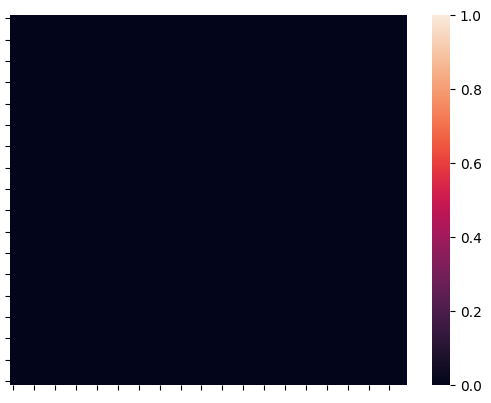

In [116]:
image = cs_datas[567] - VTAs[567]
depth = 38
data = image[:,:,depth]
ax = sb.heatmap(data, vmax=np.max(image), vmin=np.min(image))
ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set(yticklabels=[])
ax.set(ylabel=None)
plt.show()